In [1]:
using RigidBodyTreeInspector
using RigidBodyDynamics
import DataStructures: OrderedDict
using GeometryTypes
using StaticArrays
using CoordinateTransformations
using DataFrames, DataArrays
using Gadfly

adding: /home/rdeits/locomotion/explorations/point-cloud-signed-distance/packages/v0.5/DrakeVisualizer/src/lcmtypes to the python path


INFO: Recompiling stale cache file /home/rdeits/locomotion/explorations/point-cloud-signed-distance/packages/lib/v0.5/RigidBodyTreeInspector.ji for module RigidBodyTreeInspector.


adding: /home/rdeits/locomotion/explorations/point-cloud-signed-distance/packages/v0.5/DrakeVisualizer/src/lcmtypes to the python path


In [2]:
import Flash
reload("Flash")

In [3]:
urdf = "/home/rdeits/locomotion/explorations/point-cloud-signed-distance/examples/data/IRB140/urdf/irb_140_convhull.urdf"
mechanism = parse_urdf(Float64, urdf);

In [4]:
vis = parse_urdf(urdf, mechanism);
inspect(mechanism, vis)

Interact.Slider{Float64}(Signal{Float64}(0.0, nactions=0),"joint1.1",0.0,linspace(-3.141592653589793,3.141592653589793,51),".3f",true)

Interact.Slider{Float64}(Signal{Float64}(0.0, nactions=0),"joint2.1",0.0,linspace(-3.141592653589793,3.141592653589793,51),".3f",true)

Interact.Slider{Float64}(Signal{Float64}(0.0, nactions=0),"joint3.1",0.0,linspace(-3.141592653589793,3.141592653589793,51),".3f",true)

Interact.Slider{Float64}(Signal{Float64}(0.0, nactions=0),"joint4.1",0.0,linspace(-3.141592653589793,3.141592653589793,51),".3f",true)

Interact.Slider{Float64}(Signal{Float64}(0.0, nactions=0),"joint5.1",0.0,linspace(-3.141592653589793,3.141592653589793,51),".3f",true)

Interact.Slider{Float64}(Signal{Float64}(0.0, nactions=0),"joint6.1",0.0,linspace(-3.141592653589793,3.141592653589793,51),".3f",true)

nothing

In [5]:
# Construct the sensor and draw its view rays for debugging
sensor = Flash.DepthSensors.Kinect(41, 41);
camera_origin = SVector(0., 1.5, 0.5)
camera_tform = compose(Translation(camera_origin), LinearMap(AngleAxis(pi/2, 1, 0, 0)))
Flash.DepthSensors.draw_rays(sensor, camera_tform)

In [6]:
vis_data = RigidBodyTreeInspector.parse_urdf_visuals(urdf, mechanism);

In [7]:
surfaces = Vector{Flash.Surface{Float64}}()
for (i, node) in enumerate(mechanism.toposortedTree)
    body = node.vertexData
    mesh = vis_data[i].geometry_data[1].geometry
    tform = vis_data[i].geometry_data[1].transform
    verts = vertices(mesh)
    surface_points = [Point3D(body.frame, tform(SVector{3, Float64}(v...))) for v in verts]
    skeleton_points = Vector{Point3D{Float64}}()
    geometries = OrderedDict(body => Flash.BodyGeometry(surface_points, skeleton_points))
    push!(surfaces, Flash.Surface(geometries, Flash.RigidPolytope()))
end

model = Flash.Manipulator(mechanism, surfaces);
state = Flash.ManipulatorState(model);
skin = Flash.skin(state);

In [8]:
Visualizer(DrakeVisualizer.contour_mesh(skin, Vec(-.5, -.5, -.25), Vec(1., .5, 1), 0.01, 0.05))

DrakeVisualizer.Visualizer(DrakeVisualizer.Robot(DrakeVisualizer.Link[DrakeVisualizer.Link(DrakeVisualizer.GeometryData[DrakeVisualizer.GeometryData{CoordinateTransformations.IdentityTransformation,GeometryTypes.HomogenousMesh{FixedSizeArrays.Point{3,Float64},GeometryTypes.Face{3,Int64,0},Void,Void,Void,Void,Void}}(HomogenousMesh(
    vertices: 2242xFixedSizeArrays.Point{3,Float64},     faces: 4480xGeometryTypes.Face{3,Int64,0}, )
,CoordinateTransformations.IdentityTransformation(),RGBA{Float64}(1.0,0.0,0.0,0.5))],"link")]),1,PyLCM.LCM(PyObject <LCM object at 0x7f6fd29ff540>))

In [9]:
# Difference between two angles, compensating for wraparound
# (taken from angleDiff.m in Drake)
function angle_diff(phi1, phi2)
    mod(phi2 - phi1 + pi, 2*pi) - pi;
end

angle_diff (generic function with 1 method)

In [10]:
vis_true, vis_estimated = Visualizer([convert(DrakeVisualizer.Robot, vis_data) for i in 1:2]);

In [12]:
# Now let's try to use the raycast data to recover the joint angles.
# We'll do that by choosing a true (hidden) robot state:
true_state = Flash.ManipulatorState(model)
true_origins = Flash.link_origins(true_state)
# Flash.draw(true_state, false)
DrakeVisualizer.draw(vis_true, true_origins)

# Now we can raycast that true state to get a set of sensed points:
sensed_points = Flash.DepthSensors.raycast(true_state, sensor, camera_tform)
Flash.DepthSensors.draw_points(sensed_points)

# Our cost function takes the two joint angles and returns the 
# squared sum of the value of the implicit surface at those sensed
# points. If we've recovered the true joint state, then that sum
# should be nearly zero. 
cost = Flash.CostFunctor(model, sensed_points)

wrapped_cost = x -> begin
    c = cost(x)
    origins = Flash.link_origins(model, Flash.value.(get(cost.state).mechanism_state.q))
#     origins = Flash.link_origins(get(cost.state))
    DrakeVisualizer.draw(vis_estimated, origins)
#     Flash.draw(get(cost.state), false)
    c
end

(::#18) (generic function with 1 method)

In [13]:
cost_and_gradient! = Flash.CostAndGradientFunctor(wrapped_cost)

(::#29) (generic function with 1 method)

In [14]:
trials = []

function test_gradient_descent()
    for i = 1:100
        errors = []
        xs = []
        costs = []

        # We'll initialize our estimate with a uniformly random pair
        # of joint angles
        est_state = Flash.ManipulatorState(model)
        x_estimated = copy(Flash.flatten(true_state))
        x_estimated += pi * (rand(length(x_estimated)) - 0.5)
#         set_configuration!(est_state.mechanism_state, rand(num_positions(est_state.mechanism_state)) * 2*pi)
#         rand_configuration!(est_state.mechanism_state)
#         x_estimated = Flash.flatten(est_state)
        g = zeros(x_estimated)

        # Now we use gradient descent to recover the joint angles
        for i = 1:50
            push!(xs, x_estimated)
            push!(errors, norm(angle_diff(x_estimated, true_state.mechanism_state.q)))

            # Evaluate the gradient of the point values w.r.t. the
            # joint angles:
            ci = cost_and_gradient!(g, x_estimated)
            push!(costs, ci)

            if any(isnan, g)
                @show x_estimated
                error("NaN in gradient")
            end

            # Descend the gradient
            step = -0.1 * g
            step = min.(1, step)
#             step = -ci ./ g
#             step = sign(step) .* min.(0.05, abs.(g))
            x_estimated += step
        end
        push!(trials, DataFrame(x=xs, err=errors, cost=costs))
    end
end

test_gradient_descent (generic function with 1 method)

In [ ]:
test_gradient_descent()

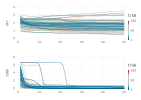

In [153]:
vstack(Gadfly.plot([layer(trial, y="err", color=i+zeros(size(trial,1)), Geom.line) for (i, trial) in enumerate(trials)]..., 
    Guide.colorkey("trial")),
    Gadfly.plot([layer(trial, y="cost", color=i+zeros(size(trial,1)), Geom.line) for (i, trial) in enumerate(trials)]..., 
    Guide.colorkey("trial")))